In this notebook I train an unsupervised model and view the word vectors that fastText comes up with. I do a little bit of exploration of these word vectors. These methods can be used for further visualization of other trained models for transparency with the model.

In [46]:
import fasttext
import pandas as pd
import numpy as np
import string
import collections
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [6]:
df = pd.read_csv("../data/pandas-dev-_-pandas.csv")

In [7]:
transdict = {p: " " + p + " " for p in string.punctuation}
translator = str.maketrans(transdict)

# preprocessing
df = df[["title", "body"]]
df = df.dropna()
df["body"] = df["body"].apply(lambda x: x.replace("\n", " <N> ").replace("\r", " <R> "))
df["input"] = df["title"] + " <SEP> " + df["body"]

In [8]:
with open("unsup.txt", "w") as f:
    for sent in df["input"].values:
        f.writelines([sent.lower().translate(translator)])

In [9]:
model = fasttext.train_unsupervised("unsup.txt")

In [15]:
np.random.choice(model.words, 50)

array(['enhancements', 'tlmaloney', 'u2mgztnuui', '776953', 'sysdeps',
       '150ms', 'py37h1350720', '654321', '700167741194332', '495847',
       'it', 'testtimestamptzoperations', 'tempinfo', 'thead', 'nullable',
       'template', 'weekofmonth', '1337600', '3749', 'r140619601',
       'delegates', 'velocity', '1649', '20150105', 'bs', 'lastord',
       'u05dd', 'sortindex', '089529', 'rjust', 'datetimeindexresampler',
       '3543', 'openbsd', 'progressbar', 'sends', '1559', 'module',
       'blurb', 'classes', 'ufloat', 'tail', '72ms', '2607', 'forked',
       'ser32', '2930', '1627', 'zz', 'd6ac987968b6', 'backtrace'],
      dtype='<U305')

In [16]:
cnt = collections.Counter([])

with open("unsup.txt", "r") as f:
    for line in f.readlines():
        cnt.update(word_tokenize(line))

In [31]:
len(cnt)

101925

In [116]:
words = [
    word for word, count in cnt.most_common(1000) if word not in string.punctuation
]
words = [word for word in words if not word.isnumeric()]
words = [word for word in words if word not in stopwords.words("english")]
words = [word for word in words if not len(word) <= 3]

In [117]:
len(words)

631

In [118]:
def score(word1, word2):
    v1 = model[word1]
    v2 = model[word2]
    return v1 @ v2 / np.sqrt((np.linalg.norm(v1) ** 2 * np.linalg.norm(v2) ** 2))


def closest_neighbors(word1, n=10):
    scores = [(score(word2, word1), word2) for word2 in words if word2 != word1]
    return sorted(scores, reverse=True)[:n]

In [126]:
rndm = np.random.choice(words, 7, replace=False)

In [127]:
all_words = []
rndm = list(rndm)
for i in rndm:
    all_words.append(i)
    all_words += [word for n, word in closest_neighbors(i)]

all_words = np.unique(all_words)

In [128]:
vectors = [model[word] for word in all_words]

reduced = TSNE().fit_transform(vectors)

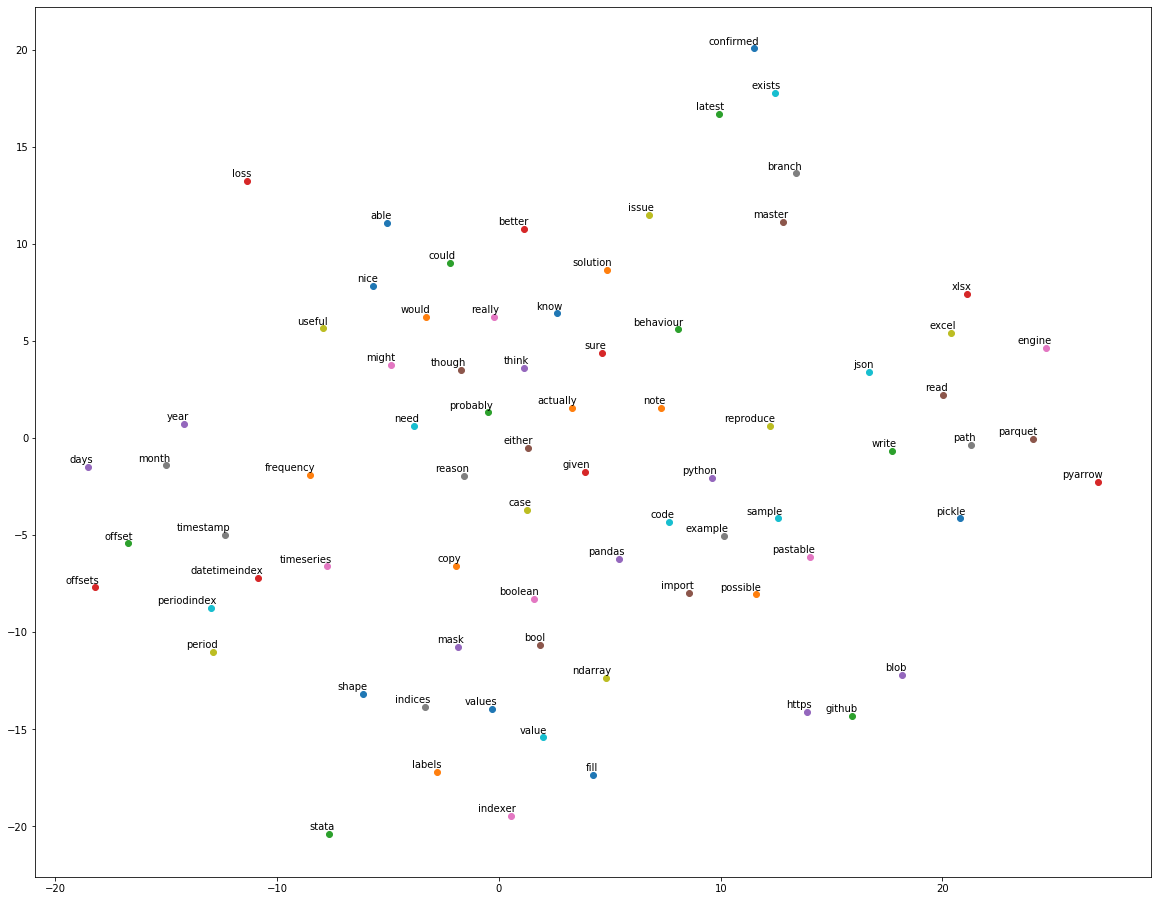

In [131]:
x = []
y = []
for value in reduced:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(20, 16))
for i in range(len(x)):
    plt.scatter(x[i], y[i])
    plt.annotate(
        all_words[i],
        xy=(x[i], y[i]),
        xytext=(5, 2),
        textcoords="offset points",
        ha="right",
        va="bottom",
    )
plt.savefig("ft")

In [123]:
closest_neighbors("groupby")

[(0.7544541183699501, 'transform'),
 (0.6975266609241625, 'grouper'),
 (0.6817463318826432, 'group'),
 (0.6788143856901581, 'rank'),
 (0.6646681420006492, 'groupbymethods'),
 (0.6544956320042304, 'transformation'),
 (0.6348136504614907, 'aggregate'),
 (0.623017986493538, 'field'),
 (0.621110126339491, 'apply'),
 (0.5807291049788028, 'resample')]